# Imports

In [1]:
!pip install pytorch_lightning -qqq
import pytorch_lightning
!pip install neptune
import neptune

#run = neptune.init_run(
#    project="fabiogr/Projeto-IA901",
#    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJlZjFhY2M5ZS05ZTc5LTQ0ZmItYThmOS02YTQ5OTZjNGEyNDkifQ==",
#)  # your credentials

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 16.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.1/448.1 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 107.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━

In [14]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import random_split, SubsetRandomSampler
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
import pytorch_lightning as pl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image


In [3]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Carregamento dos dados

In [ ]:
#transform=transforms.Compose([
#        transforms.RandomRotation(10),      # rotate +/- 10 degrees
#        transforms.RandomHorizontalFlip(),  # reverse 50% of images
#        transforms.Resize(224),             # resize shortest side to 224 pixels
#        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
#        transforms.ToTensor(),
#        transforms.Normalize([0.485, 0.456, 0.406],
#                             [0.229, 0.224, 0.225])
#])

In [15]:
transform=transforms.Compose([
        transforms.ToTensor()
])
    

In [16]:
dataset0=datasets.ImageFolder(root='/content/gdrive/MyDrive/IA901A_Projeto/data/processed/kaggle/Alzheimer_s Dataset',transform=None)
print(len(dataset0))
class_names=dataset0.classes
print(class_names)
print(len(class_names))

6404
['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
4


In [17]:
class DataModule(pl.LightningDataModule):
    
    def __init__(self, transform=transform, batch_size=32):
        super().__init__()
        self.root_dir = '/content/gdrive/MyDrive/IA901A_Projeto/data/processed/kaggle/Alzheimer_s Dataset'
        self.transform = transform
        self.batch_size = batch_size

    def setup(self, stage=None):
        dataset = datasets.ImageFolder(root=self.root_dir, transform=self.transform)
        n_data = len(dataset)
        n_train = int(0.8 * n_data)
        n_test = n_data - n_train

        train_dataset, test_dataset = torch.utils.data.random_split(dataset, [n_train, n_test])

        self.train_dataset = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        self.test_dataset = DataLoader(test_dataset, batch_size=self.batch_size)

    def train_dataloader(self):
        return self.train_dataset

    def test_dataloader(self):
        return self.test_dataset

In [18]:
datamodule = DataModule()
datamodule.setup()

# Vizualizando imagens

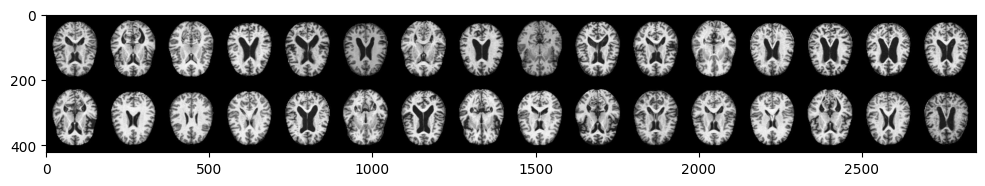

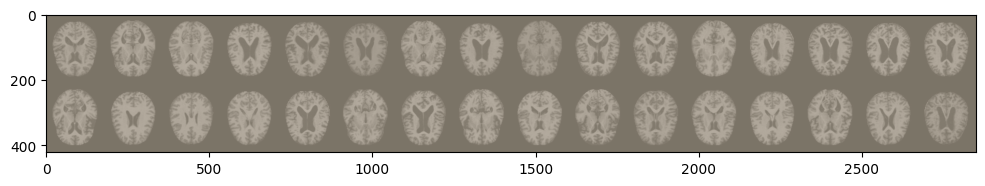

In [19]:
for images, labels in datamodule.train_dataloader():
    break
im=make_grid(images,nrow=16)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                   std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

# Definindo e treinando o modelo: AlexNet

In [9]:
print(len(class_names))

4


In [20]:
import torchmetrics
from torchmetrics import MetricCollection
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassConfusionMatrix

class MyModel(LightningModule):

    def __init__(self):
        num_classes = len(class_names)
        super().__init__()
        self.model = models.alexnet(pretrained=True)
        self.model.classifier = nn.Sequential( nn.Linear(9216,1024),
                                               nn.ReLU(),
                                               nn.Dropout(p=0.5),
                                               nn.Linear(1024, num_classes),
                                               nn.LogSoftmax(dim=1))
        # TorchMetrics
        metrics = MetricCollection([
            MulticlassAccuracy(num_classes),
            MulticlassPrecision(num_classes),
            MulticlassRecall(num_classes)
        ])
        self.train_metrics = metrics.clone(prefix='train_')
        self.val_metrics = metrics.clone(prefix='val_')
        self.test_metrics = metrics.clone(prefix='test_')

    def forward(self, x):
        x = self.model(x)
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)

        loss = F.cross_entropy(y_hat, y)
        pred = torch.flatten(y_hat.argmax(dim=1, keepdim=True))

        output = self.train_metrics(pred, y)
        self.log_dict(output)
        
        return loss

    def on_train_epoch_end(self):
        output = self.train_metrics.compute()
        print("Train Metrics: ", output)

    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)

        loss = F.cross_entropy(y_hat, y)
        pred = torch.flatten(y_hat.argmax(dim=1, keepdim=True))

        output = self.val_metrics(pred, y)
        self.log_dict(output)
        

    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)
        
        loss = F.cross_entropy(y_hat, y)
        pred = torch.flatten(y_hat.argmax(dim=1, keepdim=True))

        output = self.val_metrics(pred, y)
        self.log_dict(output)

    def on_test_epoch_end(self):
        output = self.test_metrics.compute()
        print("Test Metrics: ", output)


In [21]:
if __name__ == '__main__':
    datamodule = DataModule()
    datamodule.setup()
    model = MyModel()
    trainer = pl.Trainer(max_epochs=20)
    trainer.fit(model, datamodule)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightni

Training: 0it [00:00, ?it/s]

Train Metrics:  {'train_MulticlassAccuracy': tensor(0.2510, device='cuda:0'), 'train_MulticlassPrecision': tensor(0.2186, device='cuda:0'), 'train_MulticlassRecall': tensor(0.2510, device='cuda:0')}
Train Metrics:  {'train_MulticlassAccuracy': tensor(0.2515, device='cuda:0'), 'train_MulticlassPrecision': tensor(0.2216, device='cuda:0'), 'train_MulticlassRecall': tensor(0.2515, device='cuda:0')}
Train Metrics:  {'train_MulticlassAccuracy': tensor(0.2562, device='cuda:0'), 'train_MulticlassPrecision': tensor(0.2246, device='cuda:0'), 'train_MulticlassRecall': tensor(0.2562, device='cuda:0')}
Train Metrics:  {'train_MulticlassAccuracy': tensor(0.2657, device='cuda:0'), 'train_MulticlassPrecision': tensor(0.3478, device='cuda:0'), 'train_MulticlassRecall': tensor(0.2657, device='cuda:0')}
Train Metrics:  {'train_MulticlassAccuracy': tensor(0.2783, device='cuda:0'), 'train_MulticlassPrecision': tensor(0.3418, device='cuda:0'), 'train_MulticlassRecall': tensor(0.2783, device='cuda:0')}
Train

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [22]:
datamodule.setup(stage='test')
test_loader = datamodule.test_dataloader()
metrics = trainer.test(dataloaders=test_loader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_2/checkpoints/epoch=19-step=3220.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_2/checkpoints/epoch=19-step=3220.ckpt


Testing: 0it [00:00, ?it/s]

Test Metrics:  {'test_MulticlassAccuracy': tensor(0., device='cuda:0'), 'test_MulticlassPrecision': tensor(0., device='cuda:0'), 'test_MulticlassRecall': tensor(0., device='cuda:0')}


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MulticlassRecall was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  val_MulticlassAccuracy   │    0.7999081015586853     │
│  val_MulticlassPrecision  │    0.8150068521499634     │
│   val_MulticlassRecall    │    0.7999081015586853     │
└───────────────────────────┴───────────────────────────┘

In [ ]:
#run.stop()